Importing Necessary Libraries and Data

In [1]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.9 MB/s eta 0:00:00


In [ ]:
df_store = pd.read_csv('/content/stores_data_set (1).csv') #stores data

In [ ]:
df_sales= pd.read_csv('/content/sales_data_set (1).csv') #sales data


In [ ]:
features_df= pd.read_csv('/content/Features_data_set (1).csv') #fetures data

First Look to Data and Merging Three Dataframes¶

In [ ]:
df_store.head()

In [ ]:
df_sales.head()

In [ ]:
features_df.head()

In [ ]:
# Check for null values in the DataFrame
null_values = df_store.isnull().sum()

# Display the null values
print("Null values in each column:")
print(null_values)

Null values in each column:
Store    0
Type     0
Size     0
dtype: int64


In [ ]:
df_store.shape

(45, 3)

In [ ]:
import plotly.express as px


# Create a scatter plot with Plotly Express
fig = px.scatter(df_store, x='Type', y='Size', title='Scatter Plot of Store Size by Type',
                 labels={'Type': 'Store Type', 'Size': 'Store Size'})

# Show the plot
fig.show()


In [ ]:
# Count occurrences of 'A' in the third column
count_of_A = (df_store['Type'] == 'A').sum()
count_of_A


22

In [ ]:
count_of_B = (df_store['Type'] == 'B').sum()
count_of_B

17

In [ ]:
count_of_c = (df_store['Type'] == 'C').sum()
count_of_c

6

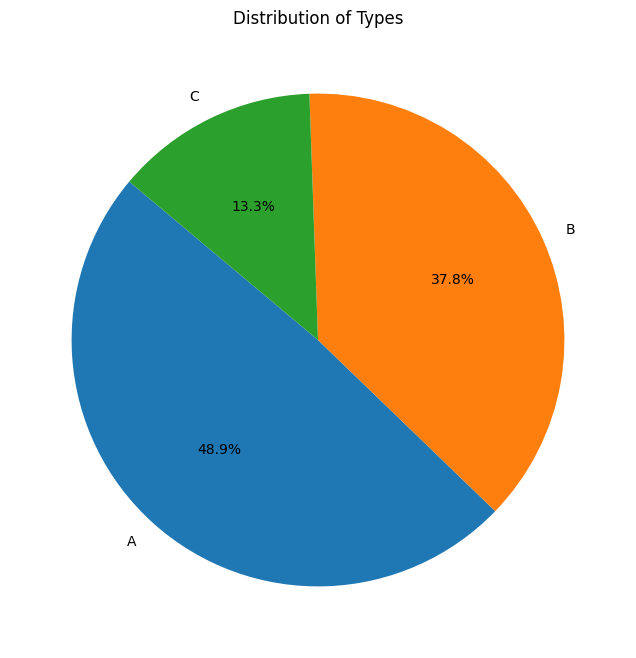

In [ ]:
# Count occurrences of each type
type_counts = df_store['Type'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Types')
plt.show()

sales data cleaning

In [ ]:
df_sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [ ]:
df_sales.shape

(421570, 5)

In [ ]:
# Check for null values in the DataFrame
null_values = df_sales.isnull().sum()

# Display the null values
print("Null values in each column:")
print(null_values)

Null values in each column:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


In [ ]:
# Convert the 'Date' column to datetime format if it's not already
df_sales['Date'] = pd.to_datetime(df_sales['Date'], dayfirst=True)

# Group by 'Dept' and calculate summary statistics for 'Weekly_Sales'
dept_summary = df_sales.groupby('Dept')['Weekly_Sales'].agg(['count', 'mean', 'min', 'max', 'sum'])

# Display the summary statistics
dept_summary

,count,mean,min,max,sum
Dept,,,,,
1,6435,19213.485088,711.11,172225.55,1.236388e+08
2,6435,43607.020113,5453.18,151090.50,2.806112e+08
3,6435,11793.698516,2.00,131564.25,7.589245e+07
4,6435,25974.630238,4695.19,72179.92,1.671467e+08
5,6347,21365.583515,-0.04,259955.82,1.356074e+08
...,...,...,...,...,...
95,6435,69824.423080,11158.06,213042.66,4.493202e+08
96,4854,15210.942761,-63.80,63978.78,7.383392e+07
97,6278,14255.576919,-9.92,49034.16,8.949651e+07


In [ ]:
# Find negative values in 'Weekly_Sales'
negative_values = df_sales[df_sales['Weekly_Sales'] < 0]

# Display the rows with negative 'Weekly_Sales'
print("Rows with Negative Weekly Sales:")
print(negative_values)

Rows with Negative Weekly Sales:
        Store  Dept       Date  Weekly_Sales  IsHoliday
846         1     6 2012-08-10       -139.65      False
2384        1    18 2012-05-04         -1.27      False
6048        1    47 2010-02-19       -863.00      False
6049        1    47 2010-03-12       -698.00      False
6051        1    47 2010-10-08        -58.00      False
...       ...   ...        ...           ...        ...
419597     45    80 2010-02-12         -0.43       True
419598     45    80 2010-02-19         -0.27      False
419603     45    80 2010-04-16         -1.61      False
419614     45    80 2010-07-02         -0.27      False
419640     45    80 2011-02-11         -0.24       True

[1285 rows x 5 columns]


1258 rows are having negative sales values which cannot happen in real world.and its less than 0.1% of the data. which can be converted to zero.




In [ ]:
# Find and replace negative values in 'Weekly_Sales' with zeros
df_sales['Weekly_Sales'] = df_sales['Weekly_Sales'].apply(lambda x: max(0, x))

# Display the modified DataFrame
print("DataFrame with Negative Weekly Sales Replaced by Zero:")
print(df_sales)

DataFrame with Negative Weekly Sales Replaced by Zero:
        Store  Dept       Date  Weekly_Sales  IsHoliday
0           1     1 2010-02-05      24924.50      False
1           1     1 2010-02-12      46039.49       True
2           1     1 2010-02-19      41595.55      False
3           1     1 2010-02-26      19403.54      False
4           1     1 2010-03-05      21827.90      False
...       ...   ...        ...           ...        ...
421565     45    98 2012-09-28        508.37      False
421566     45    98 2012-10-05        628.10      False
421567     45    98 2012-10-12       1061.02      False
421568     45    98 2012-10-19        760.01      False
421569     45    98 2012-10-26       1076.80      False

[421570 rows x 5 columns]


In [ ]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [ ]:
# Group by 'Dept' and 'IsHoliday', and sum the 'Weekly_Sales'
sales_by_dept_holiday = df_sales.groupby(['Dept', 'IsHoliday'])['Weekly_Sales'].sum().reset_index()

# Display the result
print("Weekly Sales by Department and Holiday:")
print(sales_by_dept_holiday)

Weekly Sales by Department and Holiday:
     Dept  IsHoliday  Weekly_Sales
0       1      False  1.147716e+08
1       1       True  8.867169e+06
2       2      False  2.616197e+08
3       2       True  1.899147e+07
4       3      False  7.041132e+07
..    ...        ...           ...
157    97       True  6.133824e+06
158    98      False  3.663742e+07
159    98       True  3.191647e+06
160    99      False  2.391368e+05
161    99       True  1.192726e+05

[162 rows x 3 columns]


In [ ]:
# Filter rows where 'IsHoliday' is True
holiday_sales = df_sales[df_sales['IsHoliday']]

# Display the result including 'Dept' and 'Weekly_Sales'
print("Weekly Sales for Holidays by Department:")
print(holiday_sales[['Dept', 'Weekly_Sales']])

Weekly Sales for Holidays by Department:
        Dept  Weekly_Sales
1          1      46039.49
31         1      18194.74
42         1      18820.29
47         1      19124.58
53         1      37887.17
...      ...           ...
421510    98       1092.66
421521    98        794.62
421526    98        553.21
421532    98        770.86
421562    98        352.44

[29661 rows x 2 columns]


In [ ]:
# Filter rows where 'IsHoliday' is False
non_holiday_sales = df_sales[~df_sales['IsHoliday']]

# Display the result including 'Dept' and 'Weekly_Sales'
print("Weekly Sales for Non-Holidays by Department:")
print(non_holiday_sales[['Dept', 'Weekly_Sales']])

Weekly Sales for Non-Holidays by Department:
        Dept  Weekly_Sales
0          1      24924.50
2          1      41595.55
3          1      19403.54
4          1      21827.90
5          1      21043.39
...      ...           ...
421565    98        508.37
421566    98        628.10
421567    98       1061.02
421568    98        760.01
421569    98       1076.80

[391909 rows x 2 columns]


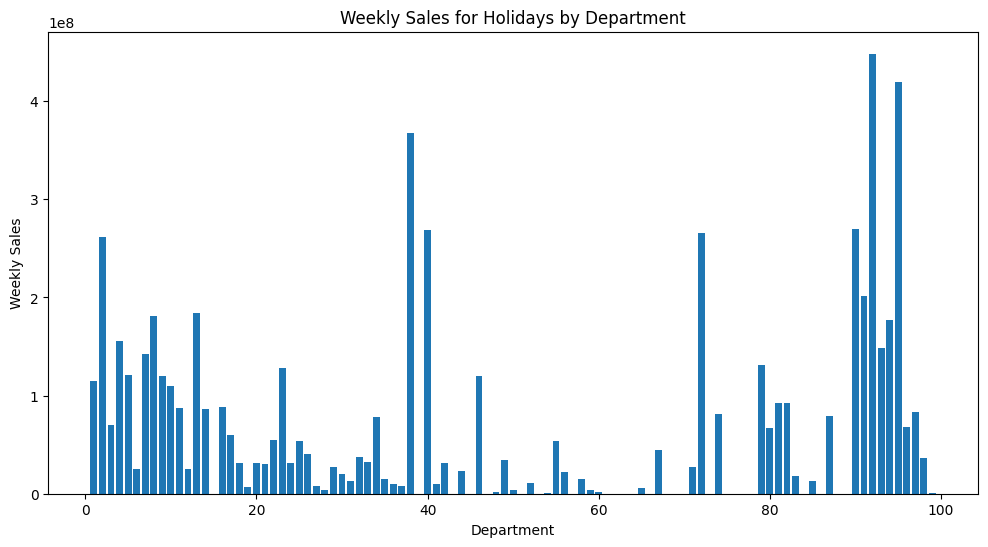

In [ ]:
# Plot the graph for weekly sales when holidays and its  department
plt.figure(figsize=(12, 6))
plt.bar(sales_by_dept_holiday['Dept'], sales_by_dept_holiday['Weekly_Sales'])
plt.title('Weekly Sales for Holidays by Department')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.show()

In [ ]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.bar(non_holiday_sales['Dept'], non_holiday_sales['Weekly_Sales'])
plt.title('Weekly Sales for Non-Holidays by Department')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.show()

In [ ]:
# Merge the two DataFrames based on a common column, e.g., 'Store'
merged_df = pd.merge(df_sales, df_store, on='Store')

# Display the merged DataFrame
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


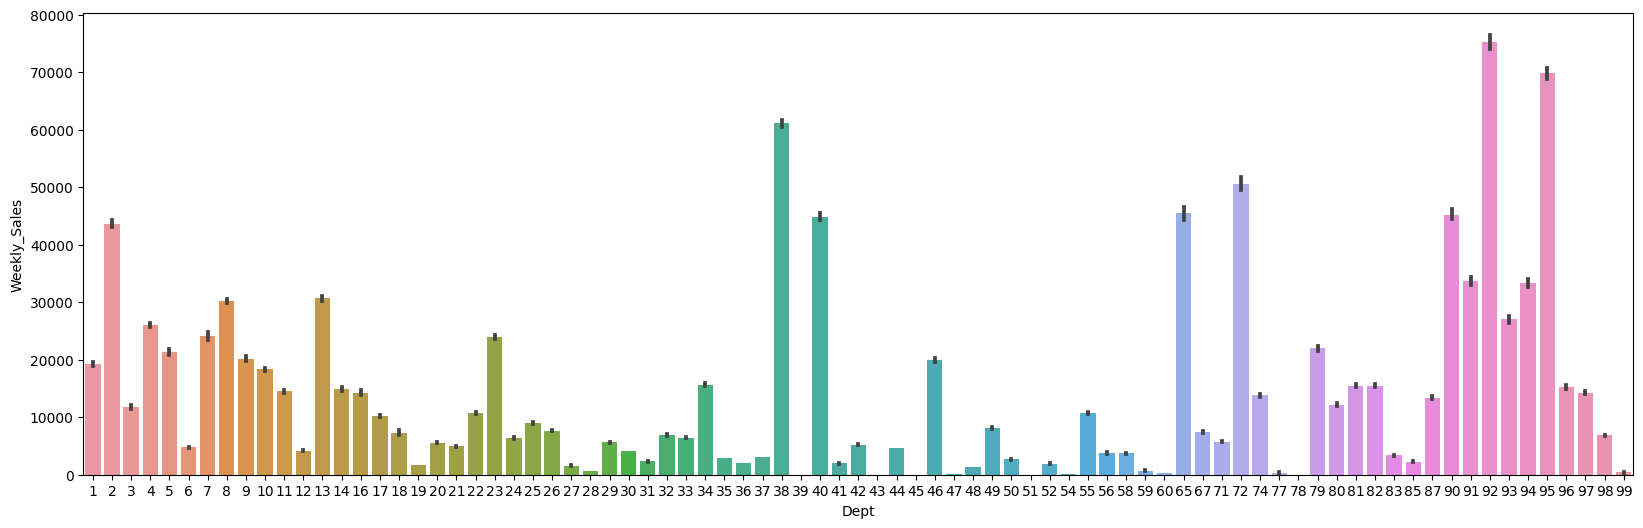

In [ ]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=merged_df)

In [ ]:
import plotly.graph_objects as go



fig = go.Figure()

for store in merged_df['Store'].unique():
    store_data = merged_df[merged_df['Store'] == store]
    for dept in store_data['Dept'].unique():
        dept_data = store_data[store_data['Dept'] == dept]
        fig.add_trace(go.Bar(x=[f'Store {store}, Dept {dept}'], y=[dept_data['Weekly_Sales'].sum()],
                             name=f'Store {store}, Dept {dept}'))

fig.update_layout(title='Weekly Sales by Store and Dept',
                  xaxis_title='Store and Dept',
                  yaxis_title='Weekly Sales',
                  barmode='stack')

fig.show()

In [ ]:
# Calculate average weekly sales per department
dept_avg_sales = merged_df.groupby('Dept')['Weekly_Sales'].mean()

# Calculate the overall average weekly sales
overall_avg_sales = merged_df['Weekly_Sales'].mean()

In [ ]:
# Display average sales per department
print("Average Sales per Department:")
print(dept_avg_sales)

# Display oveall_average sales
print("Overall Average Sales")
print(overall_avg_sales)

Average Sales per Department:
Dept
1     19213.485088
2     43607.020113
3     11793.698516
4     25974.630238
5     21365.583521
          ...     
95    69824.423080
96    15211.002268
97    14255.579560
98     6824.720490
99      415.788086
Name: Weekly_Sales, Length: 81, dtype: float64
Overall Average Sales
15981.467250207554


In [ ]:
import plotly.express as px

data = {'IsHoliday': [False, True], 'Count': [391909, 29661]}
df = pd.DataFrame(data)

# Create a bar chart using Plotly Express
fig = px.bar(df, x='IsHoliday', y='Count', text='Count', labels={'IsHoliday': 'Holiday'}, title='Count of True and False values in IsHoliday column')

# Update layout for better readability
fig.update_layout(
    xaxis_title='IsHoliday',
    yaxis_title='Count',
    showlegend=False  # Optional: hide legend since there's only one category
)

# Show the plot
fig.show()

In [ ]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
features_df.shape

(8190, 12)

In [ ]:
# Check for null values in the DataFrame
null_values = features_df.isnull().sum()

# Display the null values
print("Null values in each column of 'features_df':")
print(null_values)

Null values in each column of 'features_df':
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64


In [ ]:
# List of columns to fill null values with 0
columns_to_fill = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

# Fill null values with 0 in the specified columns
features_df[columns_to_fill] = features_df[columns_to_fill].fillna(0)

# Display the DataFrame after filling null values
features_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,28/06/2013,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,0.000000,0.000,False
8186,45,05/07/2013,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,0.000000,0.000,False
8187,45,12/07/2013,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,0.000000,0.000,False
8188,45,19/07/2013,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,0.000000,0.000,False


In [ ]:
# Check for null values in the DataFrame
null_values = features_df.isnull().sum()

# Display the null values
print("Null values in each column of 'features_df':")
print(null_values)

Null values in each column of 'features_df':
Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64


In [ ]:
# Merge the resulting DataFrame with 'features_df' based on the common column 'Store'


# Assuming 'features_df' and 'merged_df' are your DataFrames
# Convert the 'object' column in 'features_df' to datetime
features_df['Date'] = pd.to_datetime(features_df['Date'])

# Merge the DataFrames
df = pd.merge(features_df, merged_df, on=['Store', 'Date'], how='inner')

df


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_x,Dept,Weekly_Sales,IsHoliday_y,Type,Size
0,1,2010-02-19,39.93,2.514,0.00,0.00,0.0,0.00,0.00,211.289143,8.106,False,1,41595.55,False,A,151315
1,1,2010-02-19,39.93,2.514,0.00,0.00,0.0,0.00,0.00,211.289143,8.106,False,2,47928.89,False,A,151315
2,1,2010-02-19,39.93,2.514,0.00,0.00,0.0,0.00,0.00,211.289143,8.106,False,3,11523.47,False,A,151315
3,1,2010-02-19,39.93,2.514,0.00,0.00,0.0,0.00,0.00,211.289143,8.106,False,4,36826.95,False,A,151315
4,1,2010-02-19,39.93,2.514,0.00,0.00,0.0,0.00,0.00,211.289143,8.106,False,5,26468.27,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282979,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,93,2487.80,False,B,118221
282980,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,94,5203.31,False,B,118221
282981,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,95,56017.47,False,B,118221
282982,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,97,6817.48,False,B,118221


In [60]:
retail=df.to_csv('your_file_name.csv', index=False)

In [19]:
df=pd.read_csv('/content/merged.csv')

In [6]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_x,Dept,Weekly_Sales,IsHoliday_y,Type,Size
0,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,1,41595.55,False,A,151315
1,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,2,47928.89,False,A,151315
2,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,3,11523.47,False,A,151315
3,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,4,36826.95,False,A,151315
4,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,5,26468.27,False,A,151315


In [20]:
df.shape

(282984, 17)

In [30]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column

In [31]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column

In [10]:
df.head() # last ready data set

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Type,Size
0,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,1,41595.55,A,151315
1,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,2,47928.89,A,151315
2,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,3,11523.47,A,151315
3,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,4,36826.95,A,151315
4,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,5,26468.27,A,151315


In [11]:
df.shape

(282984, 16)

In [12]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,21868.284896,45268.719896,13329.226979,36344.368021,24300.923125,4988.354062,25132.551771,35189.602708,27291.916458,30387.598021,...,81549.837292,62712.159479,132790.183958,69918.767708,62681.962188,118835.748229,33327.854699,34345.410313,11748.445000,351.887083
2,30086.566146,65484.136771,17826.771875,45233.761875,31130.182292,6939.083854,41379.555729,58038.583750,34013.260937,38186.728229,...,96908.730000,79332.591771,162999.585833,69335.913333,69592.432292,141780.425937,34088.061146,39928.533438,13974.824271,611.570000
3,7185.482604,16579.570729,5578.373958,8272.628125,11872.917500,2082.580937,10384.244688,8222.984896,9156.755000,10747.763333,...,1551.828646,321.442917,7527.814583,NaN,759.747568,15633.770521,3897.580938,349.052234,29.628889,NaN
4,36509.463229,93643.603646,19413.550938,56331.595104,46616.684271,8754.902813,52874.453021,62400.224792,34610.694687,37168.940521,...,89086.132396,65964.939271,159271.465625,67675.908750,68335.387604,146669.986979,38668.495625,38943.910104,15197.505729,817.444231
5,9579.762396,12227.860417,4145.528854,9719.573125,6764.142188,1269.562917,6256.312083,13635.831250,7707.278438,9591.666979,...,3091.352917,1472.056250,7710.623333,NaN,497.976800,19219.499062,6046.364375,668.316512,29.967333,NaN
6,23313.932604,49877.320208,17014.134687,33690.241250,34951.221667,7395.400833,35196.141458,47013.214479,46809.714167,46770.331563,...,53233.325000,44662.886042,97893.506458,40592.508333,41235.578542,88096.805833,30047.083542,20155.376458,9745.554063,465.642917
7,9485.975729,22713.063542,8807.592500,14973.897500,14475.416875,6644.285833,11198.774792,13882.829271,29477.911771,21181.780521,...,14187.541146,10477.518958,26792.088125,1363.119792,722.622468,34571.423750,1190.648542,4486.173333,253.521489,NaN
8,14341.648021,35382.499792,10931.688646,20937.623438,20116.019479,3488.275000,20823.620312,26084.988750,11669.438854,20203.150833,...,38897.917604,30860.949167,59544.590000,26966.341667,25218.155417,62001.481146,23.980000,16578.426563,6845.222604,393.651818
9,11546.344271,24730.900938,7781.659375,16973.527604,19538.890104,2903.910104,14153.589375,21209.735833,12653.097917,12666.962812,...,3005.854375,850.908125,14067.765833,7.580000,703.484583,29143.285417,3568.398229,259.560000,22.068182,NaN


Store numbers begin from 1 to 45, department numbers are from 1 to 99, but some numbers are missing such as there is no 88 or 89 etc. Total number of departments is 81.

From the pivot table, it is obviously seen that there are some wrong values such as there are 0 and minus values for weekly sales. But sales amount can not be minus. Also, it is impossible for one department not to sell anything whole week. So, I will change this values.

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

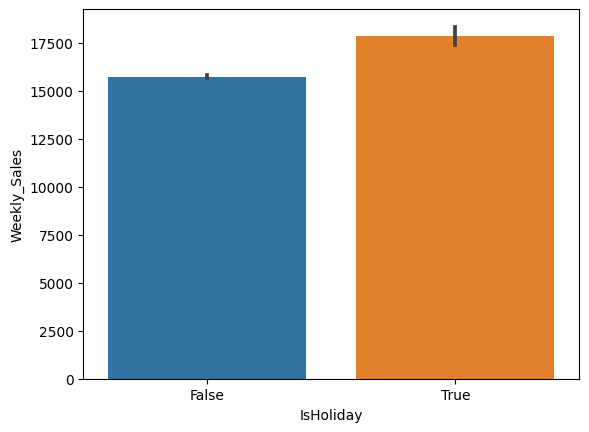

In [14]:
# IsHoliday column
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [32]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-11-26', '2010-12-31', '2011-09-09', '2011-11-25',
       '2011-12-30'], dtype=object)

In [33]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique()

91

In [ ]:
# I want to see percentages of store types.

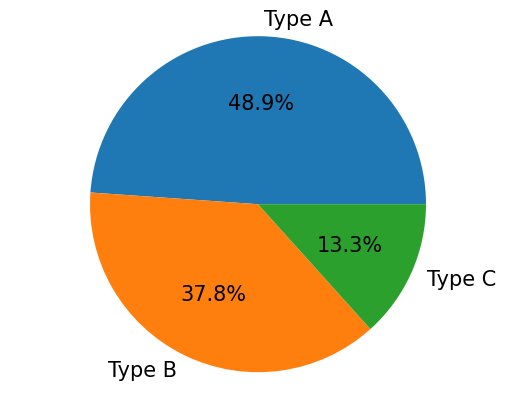

In [34]:
my_data = [48.88, 37.77 , 13.33 ]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

In [35]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Type,Size
60624,10,2010-11-26,55.33,3.162,0.00,0.0,0.00,0.00,0.00,126.669267,9.003,True,72,693099.36,B,126512
226087,35,2011-11-25,47.88,3.492,1333.24,0.0,58563.24,20.97,6386.86,140.421786,8.745,True,72,649770.18,B,103681
63218,10,2011-11-25,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,True,72,630999.19,B,126512
223691,35,2010-11-26,46.67,3.039,0.00,0.0,0.00,0.00,0.00,136.689571,8.763,True,72,627962.93,B,103681
87772,14,2010-11-26,46.15,3.039,0.00,0.0,0.00,0.00,0.00,182.783277,8.724,True,72,474330.10,A,200898


from matplotlib import pyplot as plt
_df_0['Store'].plot(kind='hist', bins=20, title='Store')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Temperature'].plot(kind='hist', bins=20, title='Temperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Fuel_Price'].plot(kind='hist', bins=20, title='Fuel_Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['MarkDown1'].plot(kind='hist', bins=20, title='MarkDown1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Store', y='Temperature', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Temperature', y='Fuel_Price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Fuel_Price', y='MarkDown1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='MarkDown1', y='MarkDown2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Store']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Date')):
  _plot_series(series, series_name, i)
  fig.legend(title='Date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Store')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Store']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Store')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Temperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Date')):
  _plot_series(series, series_name, i)
  fig.legend(title='Date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Temperature')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Temperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Temperature')

from matplotlib import pyplot as plt
_df_14['Store'].plot(kind='line', figsize=(8, 4), title='Store')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Fuel_Price'].plot(kind='line', figsize=(8, 4), title='Fuel_Price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['MarkDown1'].plot(kind='line', figsize=(8, 4), title='MarkDown1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Type'].value_counts()
    for x_label, grp in _df_18.groupby('Date')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Date')
_ = plt.ylabel('Type')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Store', y='Date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Store', y='Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['Date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='Temperature', y='Date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='Temperature', y='Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Type'].value_counts()
    for x_label, grp in _df_18.groupby('Date')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Date')
_ = plt.ylabel('Type')

In [22]:
# Also, it is not surprise that top 5 highest weekly sales are belongs to weeks in november month .

To See the Size - Type Relation

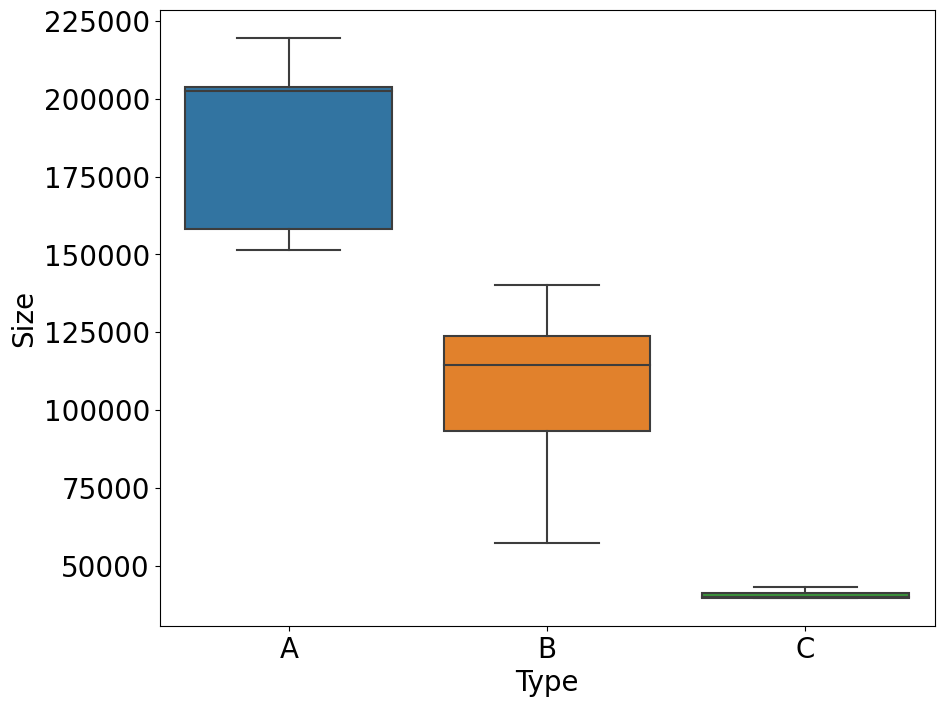

In [29]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

Size of the type of stores are consistent with sales, as expected. Higher size stores has higher sales. And, Walmart classify stores according to their sizes according to graph. After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

In [38]:
df.describe() # to see weird statistical things

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Dept,Weekly_Sales,Size
count,282984.000000,282984.000000,282984.000000,282984.000000,282984.000000,282984.000000,282984.000000,282984.000000,282984.000000,282984.000000,282984.000000,282984.000000,282984.000000
mean,22.202658,59.935594,3.380391,2593.779213,1246.490566,649.635233,1064.561544,1604.547524,171.373307,7.940535,44.250572,15853.597621,136689.988635
std,12.786038,18.213063,0.448674,6212.159734,6138.076170,6704.279722,4226.564756,3911.239599,39.205607,1.859997,30.488564,22705.975732,60987.349780
min,1.000000,5.540000,2.472000,0.000000,-265.760000,-1.000000,0.000000,0.000000,126.064000,3.879000,1.000000,0.000000,34875.000000
25%,11.000000,47.100000,2.971000,0.000000,0.000000,0.000000,0.000000,0.000000,132.064433,6.885000,18.000000,2060.337500,93638.000000
50%,22.000000,61.880000,3.486000,0.000000,0.000000,0.000000,0.000000,0.000000,182.441538,7.856000,37.000000,7534.935000,140167.000000
75%,33.000000,73.880000,3.747000,3067.640000,26.800000,4.590000,435.990000,2283.270000,212.833640,8.567000,74.000000,20005.967500,202505.000000
max,45.000000,100.140000,4.449000,88646.760000,104519.540000,141630.610000,67474.850000,105223.110000,227.232807,14.313000,99.000000,693099.360000,219622.000000


Minimum value for weekly sales is 0.01. Most probably, this value is not true but I prefer not to change them now. Because, there are many departments and many stores. It takes too much time to check each department for each store (45 store for 81 departments). So, I take averages for EDA

From the first graph, it is seen that one department between 60-80(I assume it is 72), has higher sales values. But, when we take the averages, it is seen that department 92 has higher mean sales. Department 72 is seasonal department, I think. It has higher values is some seasons but on average 92 is higher

plotting between store and sales

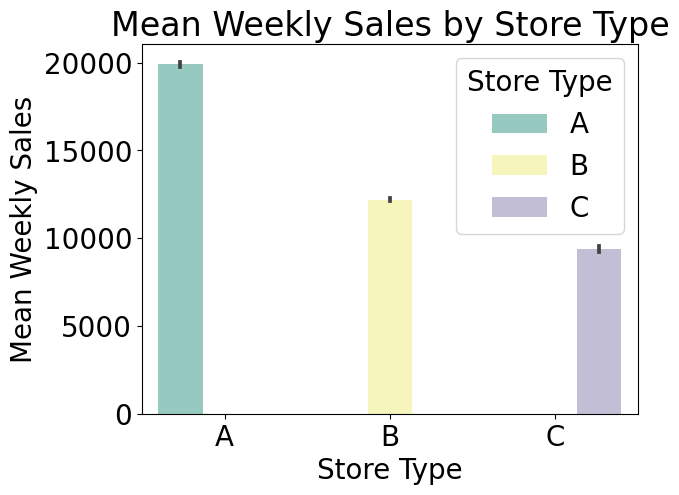

In [36]:
# Assuming 'Store_Type' is the correct column name
sns.barplot(x='Type', y='Weekly_Sales', data=df, hue='Type', palette='Set3')
plt.title('Mean Weekly Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Mean Weekly Sales')
plt.legend(title='Store Type')
plt.show()


hence TYPE A has the highest sales.

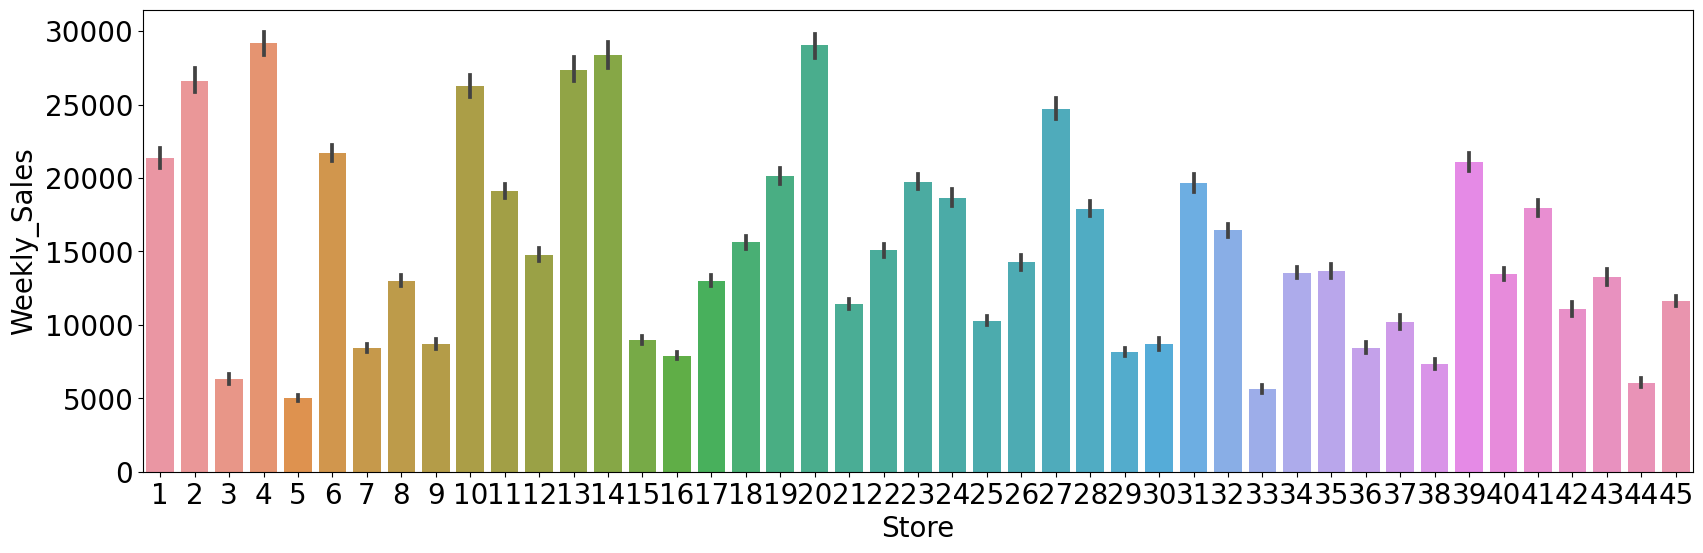

In [37]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

Same thing happens in stores. From the first graph, some stores has higher sales but on average store 20 is the best and 4 and 14 following it.

Changing Date to Datetime and Creating New Columns

In [39]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] =df['Date'].dt.week
df['month'] =df['Date'].dt.month
df['year'] =df['Date'].dt.year

In [40]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     14126.220965
2     15766.051687
3     15288.137911
4     15292.914865
5     15660.688852
6     16099.212716
7     15514.483742
8     16005.107733
9     14767.264962
10    15128.752179
11    18407.911386
12    19963.025506
Name: Weekly_Sales, dtype: float64

In [41]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16231.995476
2011    15896.317852
2012    15443.069326
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

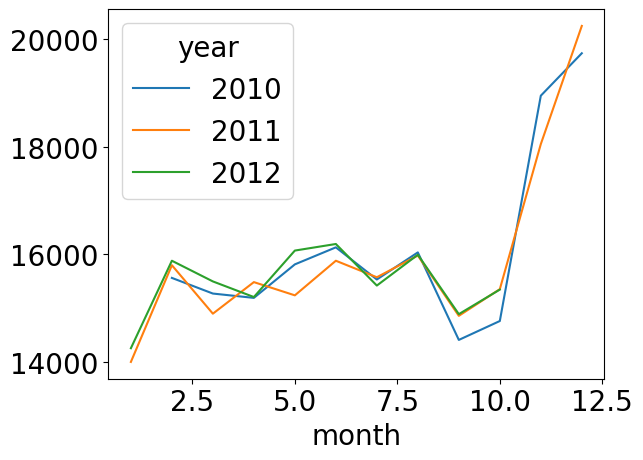

In [42]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

From the graph, it is seen that 2011 has lower sales than 2010 generally. When we look at the mean sales it is seen that 2010 has higher values, but 2012 has no information about November and December which have higher sales. Despite of 2012 has no last two months sales, it's mean is near to 2010. Most probably, it will take the first place if we get 2012 results and add them.

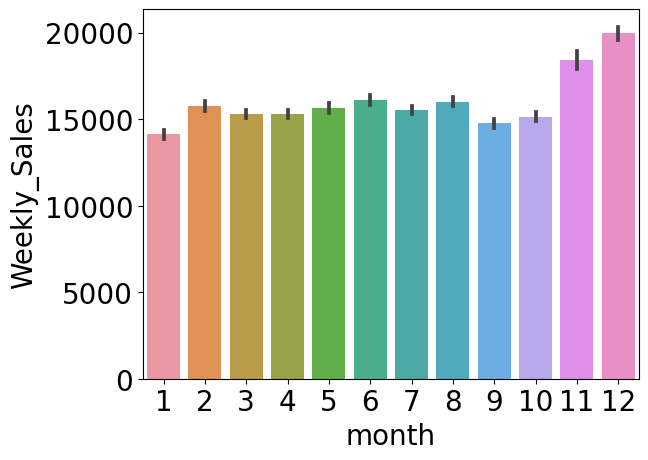

In [43]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

When we look at the graph above, the best sales are in December and November, as expected. when we take average it is obvious that December has the best value.

In [44]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26396.683899
47    22221.018981
50    20413.268756
48    16924.598067
7     16484.648054
Name: Weekly_Sales, dtype: float64

Top 5 sales averages by weekly belongs to 1-2 weeks ,when the schools are closed and festival days.

<Axes: xlabel='week'>

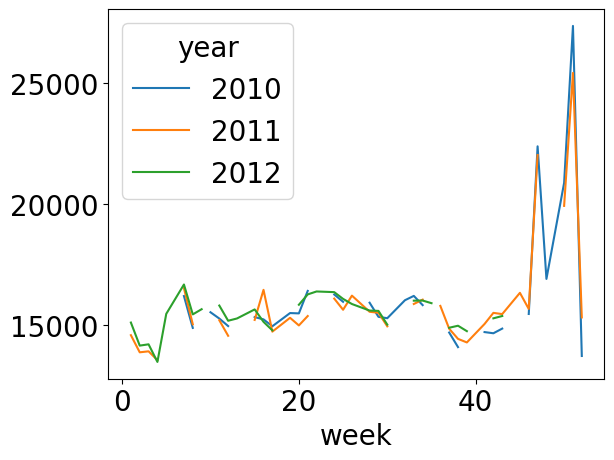

In [45]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

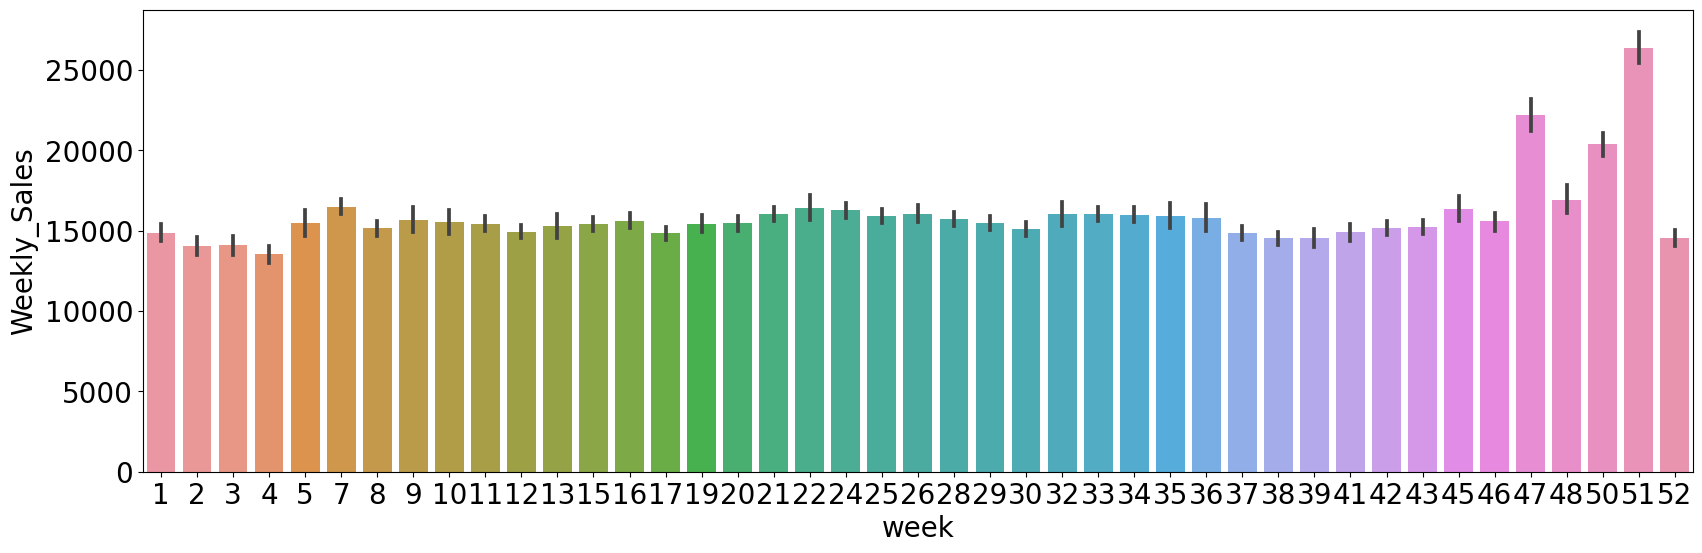

In [46]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as holidays.

Fuel Price, CPI , Unemployment , Temperature Effects

<Axes: xlabel='Fuel_Price'>

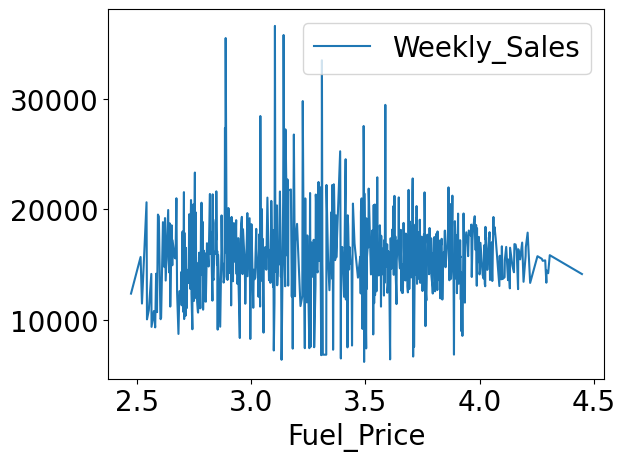

In [47]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<Axes: xlabel='Temperature'>

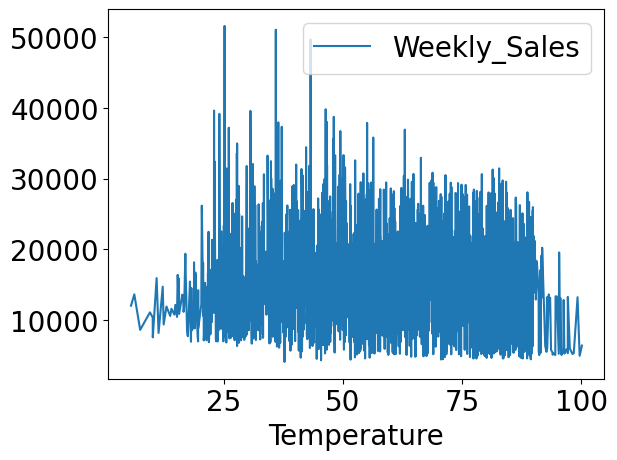

In [48]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()